# Experiment 05 - Inception Resnet v2

Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/). We used a pre-trained CNN to extract features based on B-mode images. 

The CNNfeatures are extracted using the pretrained Inception-Resnet-v2 implemented in Keras.
See reference: https://jkjung-avt.github.io/keras-inceptionresnetv2/


![Screen Shot 2020-10-12 at 2 57 22 PM](https://user-images.githubusercontent.com/23482039/95781182-47437700-0c9b-11eb-8826-594811ba3322.png)

In [1]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore")

from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import pandas as pd
from utils.compute_metrics import get_metrics, get_majority_vote,log_test_metrics
from sklearn.model_selection import GroupKFold
import mlflow

In [2]:
dataset = pd.read_pickle('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle')

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


P`<patient id [1-55]>`_image`<img id [1-10]>`.jpg

In [ ]:
# sequence of 10 to represent the suffix in the image file name
# panda dataframe that contains the path to the jpg image and its corresponding label
list_of_seq10 = [np.arange(1,11).astype('str')] * 55
list_of_seq10 = [t for tt in list_of_seq10 for t in tt]

dataset['fname'] = [f"../data/01_raw/raw_images/P{d_id}_image{d_pid}.jpg" for d_id,d_pid in list(zip(dataset['id'],list_of_seq10))]
dataset.rename(columns={'class':'labels'},inplace=True)
dataset.drop(columns=['img'], inplace=True)

In [22]:
dataset.head()

,id,labels,fat,fname
0,1,0,3,../data/01_raw/raw_images/P1_image1.jpg
1,1,0,3,../data/01_raw/raw_images/P1_image2.jpg
2,1,0,3,../data/01_raw/raw_images/P1_image3.jpg
3,1,0,3,../data/01_raw/raw_images/P1_image4.jpg
4,1,0,3,../data/01_raw/raw_images/P1_image5.jpg


In [26]:
test_metrics={}    
test_n_splits = 11
group_kfold_test = GroupKFold(n_splits=test_n_splits)
seed= 444
fold_c =1 
dataset = dataset[['fname','labels','id']]
df_pid = dataset['id']
df_y = dataset['labels']

test_metrics={}  
#majority vote results
test_metrics_mv={} 

for train_index, test_index in group_kfold_test.split(dataset, df_y, df_pid):
    
    random.seed(seed)
    random.shuffle(train_index)
    X_train, X_test = dataset.iloc[train_index], dataset.iloc[test_index]
    
    dls = ImageDataLoaders.from_df(X_train, './', folder='./', valid_pct=0.2, bs=16,item_tfms=Resize(224))
    
    #  dls = ImageDataLoaders.from_df(training_data, './', folder='./', valid_col='is_valid',bs=16,item_tfms=Resize(224))
    model = cnn_learner(dls, resnet34)
    model.fine_tune(6,lr=10e-3)
    predictions = [int(model.predict(X_test['fname'].iloc[i])[0]) for i in range(X_test.shape[0])]
    
    #get metrics with NO majority vote
    acc, auc, specificity, sensitivity = get_metrics(X_test['labels'], predictions)
    #compute majority vote metrics
    acc_mv, auc_mv, specificity_mv, sensitivity_mv = get_majority_vote(X_test['labels'], np.array(predictions))
    
    print('FOLD '+ str(fold_c) + ':  acc ' + str(acc) +  ', auc ' +  str(auc) +  ', specificity '+ str(specificity)
          + ', sensitivity ' + str(sensitivity))
    print('FOLD '+ str(fold_c) + ':  MV acc ' + str(acc_mv) +  ', MV auc ' +  str(auc_mv) +  ', MV specificity '+ str(specificity_mv)
          + ', MV sensitivity ' + str(sensitivity_mv))
    
    test_metrics[fold_c]=  {'acc':acc, 'auc':auc, 'sensitivity':sensitivity, 'specificity':specificity}
    test_metrics_mv[fold_c]=  {'acc':acc_mv, 'auc':auc_mv, 'sensitivity':sensitivity_mv, 'specificity':specificity_mv}
    
    fold_c +=1 
     
log_test_metrics(test_metrics, test_metrics_mv, test_n_splits)
    

epoch,train_loss,valid_loss,time
0,1.083064,0.982858,00:04


epoch,train_loss,valid_loss,time
0,0.451311,0.171575,00:04
1,0.394953,0.175406,00:04
2,0.287713,0.046455,00:04
3,0.214756,0.036754,00:04
4,0.138697,0.043622,00:04


FOLD 1:  acc 0.94, auc 0.9249999999999999, specificity 0.85, sensitivity 1.0
FOLD 1:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,1.104081,0.783690,00:04


epoch,train_loss,valid_loss,time
0,0.488708,0.270869,00:04
1,0.350608,0.012143,00:04
2,0.261129,0.058210,00:04
3,0.253113,0.000963,00:04
4,0.163481,0.001677,00:04


FOLD 2:  acc 0.84, auc 0.8666666666666667, specificity 0.7333333333333333, sensitivity 1.0
FOLD 2:  MV acc 0.8, MV auc 0.8333333333333334, MV specificity 0.6666666666666666, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,1.018809,0.397485,00:04


epoch,train_loss,valid_loss,time
0,0.625372,0.142981,00:04
1,0.433136,0.295825,00:04
2,0.290977,0.065827,00:04
3,0.204549,0.003931,00:04
4,0.130122,0.001414,00:04


FOLD 3:  acc 0.64, auc 0.5666666666666667, specificity 0.2, sensitivity 0.9333333333333333
FOLD 3:  MV acc 0.6, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.875461,0.482183,00:04


epoch,train_loss,valid_loss,time
0,0.523448,0.186285,00:04
1,0.396941,0.039249,00:04
2,0.284469,0.054515,00:04
3,0.229249,0.021436,00:04
4,0.168583,0.012311,00:04


FOLD 4:  acc 0.84, auc 0.6, specificity 0.2, sensitivity 1.0
FOLD 4:  MV acc 0.8, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.823408,0.450769,00:04


epoch,train_loss,valid_loss,time
0,0.497508,0.158305,00:04
1,0.336319,0.123627,00:04
2,0.276192,0.105507,00:04
3,0.180287,0.061864,00:04
4,0.134134,0.044733,00:04


FOLD 5:  acc 0.96, auc 0.9, specificity 0.8, sensitivity 1.0
FOLD 5:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.978904,0.326686,00:05


epoch,train_loss,valid_loss,time
0,0.503600,0.251698,00:05
1,0.369367,0.036949,00:04
2,0.272438,0.227410,00:04
3,0.210593,0.027102,00:04
4,0.158979,0.009616,00:04


FOLD 6:  acc 0.92, auc 0.8, specificity 0.6, sensitivity 1.0
FOLD 6:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.749687,1.773137,00:04


epoch,train_loss,valid_loss,time
0,0.484082,0.204195,00:04
1,0.465540,1.151252,00:04
2,0.359594,0.251254,00:04
3,0.221011,0.040582,00:04
4,0.159108,0.003450,00:04


FOLD 7:  acc 0.68, auc 0.8, specificity 1.0, sensitivity 0.6
FOLD 7:  MV acc 0.6, MV auc 0.75, MV specificity 1.0, MV sensitivity 0.5


epoch,train_loss,valid_loss,time
0,0.930115,0.753168,00:04


epoch,train_loss,valid_loss,time
0,0.416925,0.165612,00:04
1,0.368116,0.107451,00:04
2,0.271307,0.017911,00:04
3,0.202777,0.000901,00:04
4,0.166496,0.002012,00:04


FOLD 8:  acc 0.98, auc 0.9500000000000001, specificity 0.9, sensitivity 1.0
FOLD 8:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.857134,0.989450,00:04


epoch,train_loss,valid_loss,time
0,0.522229,0.173847,00:04
1,0.411589,0.224571,00:04
2,0.256487,0.029968,00:04
3,0.167523,0.009049,00:04
4,0.132692,0.009833,00:04


FOLD 9:  acc 0.82, auc 0.625, specificity 0.3, sensitivity 0.95
FOLD 9:  MV acc 0.8, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


epoch,train_loss,valid_loss,time
0,0.912108,0.310773,00:04


epoch,train_loss,valid_loss,time
0,0.436632,1.587081,00:04
1,0.382819,0.089693,00:04
2,0.350681,0.001486,00:04
3,0.251119,0.053502,00:04
4,0.159354,0.003052,00:04


FOLD 10:  acc 0.48, auc 0.3, specificity 0.0, sensitivity 0.6
FOLD 10:  MV acc 0.4, MV auc 0.25, MV specificity 0.0, MV sensitivity 0.5


epoch,train_loss,valid_loss,time
0,0.844502,0.581781,00:04


epoch,train_loss,valid_loss,time
0,0.466523,0.246541,00:04
1,0.390355,0.221099,00:04
2,0.366698,0.153306,00:04
3,0.237818,0.031118,00:04
4,0.156090,0.006697,00:04


FOLD 11:  acc 0.78, auc 0.8166666666666667, specificity 0.6333333333333333, sensitivity 1.0
FOLD 11:  MV acc 0.8, MV auc 0.8333333333333334, MV specificity 0.6666666666666666, MV sensitivity 1.0
INFO: 'experiment_per_model' does not exist. Creating a new experiment
Experiment done


In [ ]:
train_data['is_valid'] = False
valid_data['is_valid'] = True

training_data = pd.concat([train_data,valid_data],axis=0).reset_index(drop=True).sample(frac=1,random_state=2020)
_ = training_data.pop('id')

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
dls = ImageDataLoaders.from_df(training_data, './', folder='./', valid_col='is_valid',bs=16,item_tfms=Resize(224))

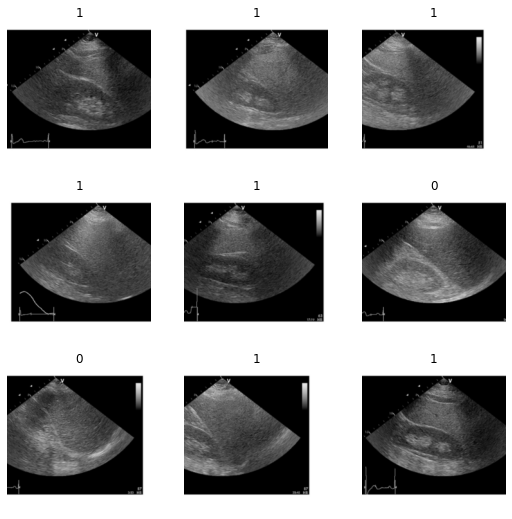

In [9]:
dls.show_batch()

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=2.75422871709452e-06)

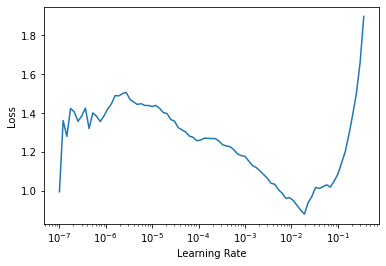

In [11]:
learn.lr_find()

In [26]:
preds = [learn.predict(test_data['fname'].iloc[i]) for i in range(test_data.shape[0])]

In [27]:
real_preds = [int(pred[0]) for pred in preds]

In [29]:
preds


[('0', tensor(0), tensor([1.0000e+00, 1.5922e-06])),
 ('0', tensor(0), tensor([9.9999e-01, 6.7350e-06])),
 ('0', tensor(0), tensor([9.9999e-01, 9.8801e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.3415e-06])),
 ('0', tensor(0), tensor([9.9998e-01, 2.0316e-05])),
 ('0', tensor(0), tensor([1.0000e+00, 6.8242e-09])),
 ('0', tensor(0), tensor([1.0000e+00, 1.2546e-07])),
 ('0', tensor(0), tensor([1.0000e+00, 1.6448e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.8203e-06])),
 ('0', tensor(0), tensor([1.0000e+00, 2.9626e-06])),
 ('0', tensor(0), tensor([0.8660, 0.1340])),
 ('0', tensor(0), tensor([0.7482, 0.2518])),
 ('0', tensor(0), tensor([0.8198, 0.1802])),
 ('0', tensor(0), tensor([0.9817, 0.0183])),
 ('0', tensor(0), tensor([0.8206, 0.1794])),
 ('0', tensor(0), tensor([0.7541, 0.2459])),
 ('1', tensor(1), tensor([0.2996, 0.7004])),
 ('1', tensor(1), tensor([0.3755, 0.6245])),
 ('0', tensor(0), tensor([0.8812, 0.1188])),
 ('0', tensor(0), tensor([0.6180, 0.3820])),
 ('1', tensor(1), te

In [28]:
accuracy_score(test_data['labels'].values, np.array(real_preds))

0.9333333333333333

In [ ]:
# note the id of the patients in the test set
test_data['id'].unique()